### 1 - Install the necessary packages

In [ ]:
!pip -q install ./python

### 2 - Importing the necessary packages


We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from agent import *

### 3 - Starting the Unity environment

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="C:\\Users\\levy0\\Documents\\Udacity\\projects\\Tennis_Windows_x86_64\\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


  ### 4 - Getting some information of the state and action spaces

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 5 - The DDPG trainning function


In [4]:
def ddpg_trainning():
    
    num_agents = 2
    id_agents = np.arange(num_agents)
    
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = env_info.vector_observations.shape[1]
    
    action_size = brain.vector_action_space_size
    
    agent_1 = Agent(state_size,action_size,0)
    agent_2 = Agent(state_size,action_size,1)
    
    scores = []
    scores_window = deque(maxlen=100)
    solved = False
    
    theta=0.15 
    sigma=0.20
    NOISE_DECAY = 1.0 #0.9999
    
    for i_episode in range(5000):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(2)
        theta *= NOISE_DECAY
        sigma *= NOISE_DECAY
        
        
        for i in range(1000):
            
            actions = np.zeros([num_agents, action_size])
            actions[0, :] = agent_1.act(states[0], True, theta, sigma)
            actions[1, :] = agent_2.act(states[1], True, theta, sigma)

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent_1.step(states, actions, rewards[0], next_states, dones[0])
            agent_2.step(states, actions, rewards[1], next_states, dones[1])
            
            score += rewards
            states = next_states
            if np.any(dones):
                break
                
        scores.append(np.max(score))
        scores_window.append(np.max(score))
        if i_episode % 200 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 0.5:
            solved = True
            episode_solved = i_episode-100
            torch.save(agent_1.actor_local.state_dict(), "a_1-a.pth")
            torch.save(agent_1.critic_local.state_dict(), "a_1-c.pth")
            torch.save(agent_2.actor_local.state_dict(), "a_2-a.pth")
            torch.save(agent_2.critic_local.state_dict(), "a_2-c.pth")
            
            break
    if solved:
        print('\nEnvironment solved in {:d} episodes!'.format(episode_solved))
    else:
        print("Environment not solved")
        
    return scores

### 6 - Trainning and solving

Episode 0	Average Score: 0.000
Episode 200	Average Score: 0.001
Episode 400	Average Score: 0.001
Episode 600	Average Score: 0.000
Episode 800	Average Score: 0.000
Episode 1000	Average Score: 0.004
Episode 1200	Average Score: 0.017
Episode 1400	Average Score: 0.003
Episode 1600	Average Score: 0.001
Episode 1800	Average Score: 0.002
Episode 2000	Average Score: 0.014
Episode 2200	Average Score: 0.025
Episode 2400	Average Score: 0.057
Episode 2600	Average Score: 0.083
Episode 2800	Average Score: 0.099
Episode 3000	Average Score: 0.133
Episode 3200	Average Score: 0.197
Episode 3400	Average Score: 0.490

Environment solved in 3301 episodes!


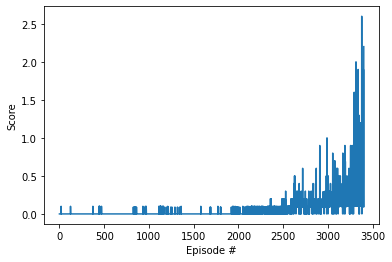

In [5]:
scores = ddpg_trainning()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7 - Closing the environment

In [ ]:
env.close()